# CDAW CME Catalog Analysis Notebook
This notebook is for analyzing current CDAW CME catalog to look for differences in CMEs.

Want to understand estimated durations of CME events and build a histogram of this 
data.

In [1]:
import requests
import pandas as pd

In [2]:
# pull the cme catalog to local disk
cme_catalog_url = 'https://cdaw.gsfc.nasa.gov/CME_list/UNIVERSAL/text_ver/univ_all.txt'
response = requests.get(cme_catalog_url, allow_redirects=True)
response

<Response [200]>

In [3]:
# cache locally, just in case..
open('../cdaw_catalog.txt', 'wb').write(response.content)

3567412

In [4]:
# parse out data into string lines from byte block
raw_lines = response.content.decode('utf-8').split('\n')

In [5]:
#snag field names from top of file. Its not entirely correct, 
# but 'good enough' for now
fields = raw_lines[1].split()
fields

['Date',
 'Time',
 'Central',
 'Width',
 'Linear',
 '2nd',
 'order',
 'speed',
 'Accel',
 'Mass',
 'Kinetic',
 'MPA',
 'Remarks']

In [6]:
# parse remainder of lines into dataframe using regex pattern
# only date and time fields appear to be consistently same format,
# we have to guard against non-numbers in all of the other columns
import re

pattern_str = r"^(\d{4}/\d{2}/\d{2})\s+(\d{2}:\d{2}:\d{2})\s+(\S+)\s+(\S+)\s+(\S+)\s+" +\
              r"(\S+)\s+(\S+)\s+(\S+)\s+(\S+?)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S[\S|\s]+)?$"
pattern = re.compile(pattern_str)

data_arr = { fld:[] for fld in fields }
# parse remainder into columns
for line in raw_lines[4:]:
    m = pattern.match(line)
    if m:
        for grp in range(1,len(m.groups())+1): 
            #print(f"{grp}: %s" % m.group(grp))
            data_arr[fields[grp-1]].append(m.group(grp))
    else:
        print (f"Warning: cannot parse line:\n  {line}")
        
raw_data = pd.DataFrame(data_arr)
raw_data

  2001/10/06  18:06:05    100    104    296     275    318    319      1.1    4.3e+15    1.9e+30     74   ]
  2014/11/23  16:12:05     94     57    601     548    661    647      5.0    1.3e+15    2.3e+30     96   \
  2016/12/30  02:24:05    232     25    333     321    346    354      1.0    9.8e+14    5.5e+29    231   n
  


,Date,Time,Central,Width,Linear,2nd,order,speed,Accel,Mass,Kinetic,MPA,Remarks
0,1996/01/11,00:14:36,267,18,499,571,426,0,-64.3*,-------,-------,272,Only C3
1,1996/01/13,22:08:30,265,16,290,278,303,372,2.8*,-------,-------,266,Only C3
2,1996/01/15,07:01:10,262,43,525,600,454,0,-31.1,-------,-------,272,Only C3
3,1996/01/22,03:11:01,105,37,267,401,130,0,-126.3*,7.1e+13*,2.5e+28*,103,Very Poor Event; Only C3
4,1996/01/26,09:16:19,90,27,262,254,271,322,1.9*,3.0e+14,1.0e+29,90,Poor Event; Only C3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30313,2020/05/29,11:24:05,84,52,347,406,288,0,-21.9*,-------,-------,68,Poor Event; Only C2
30314,2020/05/29,15:12:05,83,46,204,215,193,0,-2.8*,-------,-------,74,Poor Event; Only C2
30315,2020/05/29,17:36:05,76,34,210,295,120,0,-19.3*,-------,-------,73,Poor Event; Only C2
30316,2020/05/30,01:25:43,80,39,269,203,339,331,2.8,-------,-------,86,None


In [7]:
# filter out data, accelerations with "*" or "------"
# are either unreliable (too few measurements) or no measurement could be made

#filtered = raw_data[raw_data['Accel']!='------']
#filtered = filtered[filtered.Accel.str.contains('\*') == False]
#filtered

In [10]:
# Data Cleaning: filter out Bad/Poor data: Missing Linear speed ('------') and
# 'Very Poor Event' and 'None' in Remarks
# 
cleaned = raw_data[raw_data['Linear'] != '----']
cleaned = cleaned[cleaned.Remarks.str.contains('Very Poor Event') == False]
cleaned = cleaned[cleaned.Remarks.str.contains('None') == False]
cleaned

,Date,Time,Central,Width,Linear,2nd,order,speed,Accel,Mass,Kinetic,MPA,Remarks
0,1996/01/11,00:14:36,267,18,499,571,426,0,-64.3*,-------,-------,272,Only C3
1,1996/01/13,22:08:30,265,16,290,278,303,372,2.8*,-------,-------,266,Only C3
2,1996/01/15,07:01:10,262,43,525,600,454,0,-31.1,-------,-------,272,Only C3
4,1996/01/26,09:16:19,90,27,262,254,271,322,1.9*,3.0e+14,1.0e+29,90,Poor Event; Only C3
5,1996/01/31,06:52:13,274,47,158,219,99,0,-12.3*,2.5e+14*,3.2e+28*,272,Poor Event; Only 3 points
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30311,2020/05/28,21:12:11,260,23,187,183,192,214,0.5*,-------,-------,258,Poor Event
30312,2020/05/29,08:00:05,79,37,337,373,301,0,-13.2*,-------,-------,69,Poor Event; Only C2
30313,2020/05/29,11:24:05,84,52,347,406,288,0,-21.9*,-------,-------,68,Poor Event; Only C2
30314,2020/05/29,15:12:05,83,46,204,215,193,0,-2.8*,-------,-------,74,Poor Event; Only C2


## calculate durations for each detector (C2 1.5 - 6 Rsol and C3 is 3.7 - 30 Rsol)
Our formula for duration:
  700,000 * Det_max_Rsol /speed = T_duration_det

#### C2: 4200000 / speed = T_c2
 
#### C3: 21000000 / speed = T_c3

Our formula for C3 start time delta

#### 3.7 * 700000 / speed = T_c3_start
or
#### 2590000 / speed = T_c3_start

In [12]:
c2_durations = [ 4200000./int(speed) for speed in cleaned['Linear']]
c3_durations = [ 21000000./int(speed) for speed in cleaned['Linear']]
c3_start_delta = [2590000./int(speed) for speed in cleaned['Linear']]

In [13]:
data = cleaned
data['Duration_C2'] = c2_durations
data['Duration_C3'] = c3_durations
data['StartTime_C3_Delta'] = c3_start_delta

In [14]:
data

,Date,Time,Central,Width,Linear,2nd,order,speed,Accel,Mass,Kinetic,MPA,Remarks,Duration_C2,Duration_C3,StartTime_C3_Delta
0,1996/01/11,00:14:36,267,18,499,571,426,0,-64.3*,-------,-------,272,Only C3,8416.833667,42084.168337,5190.380762
1,1996/01/13,22:08:30,265,16,290,278,303,372,2.8*,-------,-------,266,Only C3,14482.758621,72413.793103,8931.034483
2,1996/01/15,07:01:10,262,43,525,600,454,0,-31.1,-------,-------,272,Only C3,8000.000000,40000.000000,4933.333333
4,1996/01/26,09:16:19,90,27,262,254,271,322,1.9*,3.0e+14,1.0e+29,90,Poor Event; Only C3,16030.534351,80152.671756,9885.496183
5,1996/01/31,06:52:13,274,47,158,219,99,0,-12.3*,2.5e+14*,3.2e+28*,272,Poor Event; Only 3 points,26582.278481,132911.392405,16392.405063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30311,2020/05/28,21:12:11,260,23,187,183,192,214,0.5*,-------,-------,258,Poor Event,22459.893048,112299.465241,13850.267380
30312,2020/05/29,08:00:05,79,37,337,373,301,0,-13.2*,-------,-------,69,Poor Event; Only C2,12462.908012,62314.540059,7685.459941
30313,2020/05/29,11:24:05,84,52,347,406,288,0,-21.9*,-------,-------,68,Poor Event; Only C2,12103.746398,60518.731988,7463.976945
30314,2020/05/29,15:12:05,83,46,204,215,193,0,-2.8*,-------,-------,74,Poor Event; Only C2,20588.235294,102941.176471,12696.078431


In [21]:
import numpy as np
import matplotlib.pyplot as plt
    
def plot_data (xdata, ydata, xlabel="", ylabel=""):

    fig, ax = plt.subplots()
    #plt.style.use('fivethirtyeight')
    
    ax.plot(xdata, ydata, 'ro')
    ax.set_title("Foobar")
    ax.set(xlabel=xlabel, ylabel=ylabel)
    
    
def plot_hist(data, what, nbins:int=100, ylog:bool=False, xlow:int=None, xhigh:int=None, nofill:bool=False):
    
    fig, ax = plt.subplots()
        
    if nofill:
        data.hist(ax=ax, bins=nbins, bottom=0, fill=None)
    else:
        data.hist(ax=ax, bins=nbins, bottom=0)
    ax.set_title("Histogram")
    ax.set(xlabel=what, ylabel="Num/bin")
    if xlow != None and xhigh != None:
        plt.xlim(xlow, xhigh)
        
    #plt.xticks(rotation=90)
    
    #plt.style.use('fivethirtyeight')
    if ylog:
        ax.set_yscale('log')

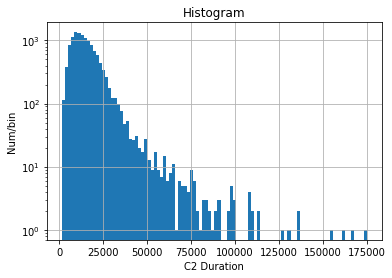

In [22]:
plot_hist(data['Duration_C2'], what='C2 Duration', ylog=True)

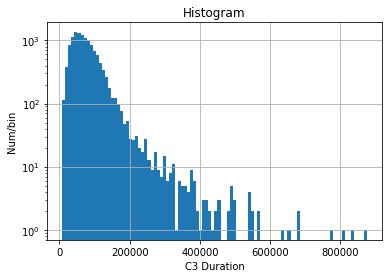

In [23]:
plot_hist(data['Duration_C3'], what='C3 Duration', ylog=True)

### TODO
1. put in column for filename and logical path
2. determine detectors which have the data so that we link to the appropriate files (not all files)